# ML Zoomcamp 2023 - Homework #6

Name: Wong Chee Fah

Email: wongcheefah@gmail.com

In [66]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

### Dataset

In this homework, we will use the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')

In [3]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


### Preparing the dataset 

For this homework, we use only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Fill missing values with zeros.
* Apply the log transform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [6]:
df = df[(df['ocean_proximity']=='<1H OCEAN') | (df['ocean_proximity']=='INLAND')]

In [7]:
df = df.fillna(0)
df['median_house_value'] = np.log1p(df['median_house_value'])

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values
y_test = df_test['median_house_value'].values

df_train.drop('median_house_value', axis=1, inplace=True)
df_val.drop('median_house_value', axis=1, inplace=True)
df_test.drop('median_house_value', axis=1, inplace=True)

In [9]:
df_train.shape, df_val.shape, df_test.shape

((9411, 9), (3138, 9), (3138, 9))

In [10]:
dv = DictVectorizer(sparse=True)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

## Question 1

Train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity`
* `total_rooms`
* `latitude`
* `population`

In [11]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_val)

In [12]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



##### Ans: `ocean_proximity`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* 0.245
* 0.545
* 0.845

In [13]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
print(f'RMSE: {np.sqrt(mean_squared_error(y_val, y_pred)):.3f}')

RMSE: 0.245


##### Ans: `0.245`

## Question 3

Experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for retrieving the answer.

- 10
- 25
- 50
- 160

In [14]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f'n: {n:>3}   RMSE: {rmse:.3f}')
    
    scores.append((n, rmse))

n:  10   RMSE: 0.245
n:  20   RMSE: 0.238
n:  30   RMSE: 0.237
n:  40   RMSE: 0.235
n:  50   RMSE: 0.235
n:  60   RMSE: 0.235
n:  70   RMSE: 0.234
n:  80   RMSE: 0.235
n:  90   RMSE: 0.234
n: 100   RMSE: 0.234
n: 110   RMSE: 0.234
n: 120   RMSE: 0.234
n: 130   RMSE: 0.234
n: 140   RMSE: 0.234
n: 150   RMSE: 0.234
n: 160   RMSE: 0.233
n: 170   RMSE: 0.233
n: 180   RMSE: 0.234
n: 190   RMSE: 0.234
n: 200   RMSE: 0.234


In [23]:
decreasing = True
i = 0

n, rmse = scores[i][0], scores[i][1]
i += 1
print(f'n: {n:>3}   RMSE: {rmse}')

while decreasing:
    last_n = n
    last_rmse = rmse
    n, rmse = scores[i][0], scores[i][1]
    decreasing = rmse < last_rmse
    print(f'n: {n:>3}   RMSE: {rmse:<19}   Less than previous RMSE: {decreasing}')
    i += 1

print()
print(f'RMSE first stopped improving at n_estimators = {last_n}')

n:  10   RMSE: 0.24495290030597153
n:  20   RMSE: 0.23833358987366804   Less than previous RMSE: True
n:  30   RMSE: 0.2365040295615984    Less than previous RMSE: True
n:  40   RMSE: 0.23509490973460045   Less than previous RMSE: True
n:  50   RMSE: 0.23475019819586204   Less than previous RMSE: True
n:  60   RMSE: 0.2345062010902977    Less than previous RMSE: True
n:  70   RMSE: 0.2344015455060835    Less than previous RMSE: True
n:  80   RMSE: 0.2345721915928697    Less than previous RMSE: False

RMSE first stopped improving at n_estimators = 70


##### Ans: `50`

## Question 4

Select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25

In [36]:
scores = []
max_depths = [10, 15, 20, 25]
max_rmse = 0

for max_depth in max_depths:
    rmses = []
    print(f'max_depth: {max_depth}')
    print('—'*13)
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth=max_depth,
                                   random_state=1,
                                   n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)
        print(f'n: {n:>3}   RMSE: {rmse}')
        max_rmse = max(rmse, max_rmse)
    
    mean_rmse = np.mean(rmses)
    print()
    print(f'Mean RMSE: {mean_rmse}')
    print()
    scores.append((max_depth, mean_rmse))

max_depth: 10
—————————————
n:  10   RMSE: 0.25068217666806397
n:  20   RMSE: 0.24745502781785714
n:  30   RMSE: 0.24626379186617842
n:  40   RMSE: 0.24502936288687294
n:  50   RMSE: 0.24543003121441526
n:  60   RMSE: 0.24522113262934922
n:  70   RMSE: 0.24528983725642312
n:  80   RMSE: 0.24553630580063834
n:  90   RMSE: 0.24545212921717777
n: 100   RMSE: 0.2453700257720694
n: 110   RMSE: 0.24526239970363062
n: 120   RMSE: 0.24505304321886626
n: 130   RMSE: 0.24478991812503073
n: 140   RMSE: 0.24457214573772543
n: 150   RMSE: 0.2445535109898143
n: 160   RMSE: 0.24445890373792142
n: 170   RMSE: 0.24441806155085397
n: 180   RMSE: 0.24452331688334136
n: 190   RMSE: 0.24471986806235071
n: 200   RMSE: 0.24472926841080214

Mean RMSE: 0.24544051287746912

max_depth: 15
—————————————
n:  10   RMSE: 0.2457272711111922
n:  20   RMSE: 0.23952881010577426
n:  30   RMSE: 0.23781306597625018
n:  40   RMSE: 0.23590339688070874
n:  50   RMSE: 0.2359295181428415
n:  60   RMSE: 0.23562429473516247
n:  7

In [37]:
min_mean_rmse = max_rmse

print('Summary')
print('—'*7)
for score in scores:
    max_depth, mean_rmse = score[0], score[1]
    print(f'max_depth: {max_depth}   Mean RMSE: {mean_rmse}')
    if mean_rmse < min_mean_rmse:
        min_mean_rmse = mean_rmse
        min_max_depth = max_depth

print()
print(f'Best max_depth: {min_max_depth}   Mean RMSE: {min_mean_rmse}')

Summary
———————
max_depth: 10   Mean RMSE: 0.24544051287746912
max_depth: 15   Mean RMSE: 0.23593809323441645
max_depth: 20   Mean RMSE: 0.23528368743179717
max_depth: 25   Mean RMSE: 0.2348961369222931

Best max_depth: 25   Mean RMSE: 0.2348961369222931


##### Ans: `25`

# Question 5

Find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income`
* `total_bedrooms`
* `longitude`

In [11]:
rf = RandomForestRegressor(n_estimators=10,
                           max_depth=20,
                           random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)

rf.feature_importances_

array([0.01495348, 0.03019435, 0.10189142, 0.0861758 , 0.33566849,
       0.29247297, 0.07380644, 0.02682069, 0.01624481, 0.02177155])

In [20]:
gini_impt_scores = dict(zip(dv.get_feature_names_out(), rf.feature_importances_))
gini_impt_scores

{'households': 0.014953476344031812,
 'housing_median_age': 0.030194348002947978,
 'latitude': 0.10189141894557846,
 'longitude': 0.08617580381806568,
 'median_income': 0.33566849340251753,
 'ocean_proximity=<1H OCEAN': 0.29247296545343116,
 'ocean_proximity=INLAND': 0.07380644294557998,
 'population': 0.026820690830484637,
 'total_bedrooms': 0.01624480660362488,
 'total_rooms': 0.021771553653737723}

In [21]:
max_gini = max(gini_impt_scores.values())
impt_feature_name = list(gini_impt_scores.keys())[list(gini_impt_scores.values()).index(max_gini)]
print(f'The most important feature is {impt_feature_name}.')

The most important feature is median_income.


##### Ans: `median_income`

## Question 6

Now train an XGBoost model. For this question, tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which `eta` leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [154]:
features = dv.get_feature_names_out()
features[5] = features[5].replace('=<', '_lteq_')
features = list(features)
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [155]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [156]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [157]:
scores = {}

In [158]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                verbose_eval=1,
                evals=watchlist)

key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [159]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                verbose_eval=1,
                evals=watchlist)

key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [160]:
scores['eta=0.3']

,num_iter,train_rmse,val_rmse
0,0,0.52449,0.52045
1,1,0.48736,0.48443
2,2,0.45433,0.45293
3,3,0.42533,0.42550
4,4,0.39987,0.40144
...,...,...,...
95,95,0.16562,0.23276
96,96,0.16524,0.23266
97,97,0.16444,0.23246
98,98,0.16383,0.23222


In [161]:
scores['eta=0.1']

,num_iter,train_rmse,val_rmse
0,0,0.44350,0.44250
1,1,0.36599,0.36916
2,2,0.31556,0.32382
3,3,0.28541,0.29965
4,4,0.26573,0.28417
...,...,...,...
95,95,0.11211,0.22908
96,96,0.11139,0.22875
97,97,0.11089,0.22864
98,98,0.11041,0.22868


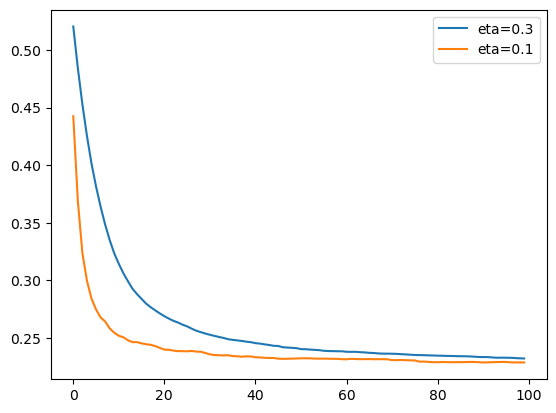

In [162]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=key)

plt.legend()

##### Ans: `0.1`